#food data classification

In [1]:
import google.colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

In [3]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#Mount google drive

In [4]:
DATASET_ROOT = "/content/drive/MyDrive/Pytorch/Image_classification"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

NUM_CLASSES = 3        # You said 3 categories
IMG_SIZE = 128         # Can change to 224 if needed

#Image Transform according to mobilenetv3

model:https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.mobilenet_v3_large

In [5]:
from torchvision import transforms


# Base ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# TRAIN transform (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# TEST / VAL transform (NO augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

#Dtaset DataLoader


Use this when images aren't in image form PIL

```
from PIL import Image
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to (28, 28)
    image = self.features[index].reshape(28,28)

    # change datatype to np.uint8
    image = image.astype(np.uint8)

    # change black&white to color -> (H,W,C) -> (C,H,W)
    image = np.stack([image]*3, axis=-1)
    #now it is (C,H,W) -> (H,W,C)

    # convert array to PIL image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)

train_dataset = CustomDataset(root=TRAIN_DIR, transform=custom_transform)
test_dataset = CustomDataset(root=TEST_DIR, transform = custom_transform)
```



In [6]:
train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_DIR,
    transform=test_transform
)

In [7]:
#DtaLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [8]:
print("Class mapping:", train_dataset.class_to_idx)

Class mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}


#**Model**

In [9]:
import torchvision.models as models

mobilev3 = models.mobilenet_v3_large(pretrained = True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 92.6MB/s]


In [10]:
mobilev3

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [11]:
for param in mobilev3.parameters():
  param.requires_grad = False


In [12]:
mobilev3.classifier =nn.Sequential(
    nn.Linear(960, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)
)

#Train

In [13]:
learning_rate = 0.0005794624755319799
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilev3.classifier.parameters(), lr=learning_rate)
mobilev3 = mobilev3.to(device)

In [14]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = mobilev3(batch_features)

    print(outputs.shape)
    print(batch_labels.shape)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

    break

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([32, 3])
torch.Size([32])
Epoch: 1 , Loss: 0.1358957439661026
torch.Size([32, 3])
torch.Size([32])
Epoch: 2 , Loss: 0.13672201335430145
torch.Size([32, 3])
torch.Size([32])
Epoch: 3 , Loss: 0.125992089509964
torch.Size([32, 3])
torch.Size([32])
Epoch: 4 , Loss: 0.1303732842206955
torch.Size([32, 3])
torch.Size([32])
Epoch: 5 , Loss: 0.12718389928340912
torch.Size([32, 3])
torch.Size([32])
Epoch: 6 , Loss: 0.1336749643087387
torch.Size([32, 3])
torch.Size([32])
Epoch: 7 , Loss: 0.12028598040342331
torch.Size([32, 3])
torch.Size([32])
Epoch: 8 , Loss: 0.11450307816267014
torch.Size([32, 3])
torch.Size([32])
Epoch: 9 , Loss: 0.1081429049372673
torch.Size([32, 3])
torch.Size([32])
Epoch: 10 , Loss: 0.1130230724811554
torch.Size([32, 3])
torch.Size([32])
Epoch: 11 , Loss: 0.1025862991809845
torch.Size([32, 3])
torch.Size([32])
Epoch: 12 , Loss: 0.10638315230607986
torch.Size([32, 3])
torch.Size([32])
Epoch: 13 , Loss: 0.10638634860515594
torch.Size([32, 3])
torch.Size([32])
Epoch

In [15]:
mobilev3.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [16]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = mobilev3(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9066666666666666


In [17]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = mobilev3(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

1.0


In [18]:
model_save_path = os.path.join(DATASET_ROOT, 'mobilev3_model.pth')
torch.save(mobilev3.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Pytorch/Image_classification/mobilev3_model.pth


# Task
Generate a graphical confusion matrix for the test data, display the total accuracy, calculate and print accuracy per category, select three random images from each category in the test data, use the trained model to predict their classes, and then display each image along with its true and predicted labels.

## Confusion Matrix Visualization and Accuracy Metrics

### Subtask:
Generate a graphical confusion matrix for the test data, display the total accuracy, and calculate and print accuracy per category.


**Reasoning**:
The subtask requires calculating and visualizing the confusion matrix, and printing accuracy metrics. First, I need to import the necessary libraries, `seaborn` and `matplotlib.pyplot`, which are essential for plotting.



In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
print("Seaborn and Matplotlib imported.")

Seaborn and Matplotlib imported.


**Reasoning**:
The subtask requires generating a graphical confusion matrix, displaying total accuracy, and calculating/printing accuracy per category. Based on the kernel state, the `all_labels`, `all_predictions`, `conf_matrix`, and `overall_accuracy` are already available. Therefore, I will now proceed to define class names, plot the confusion matrix, display overall accuracy, and calculate per-category accuracy.



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


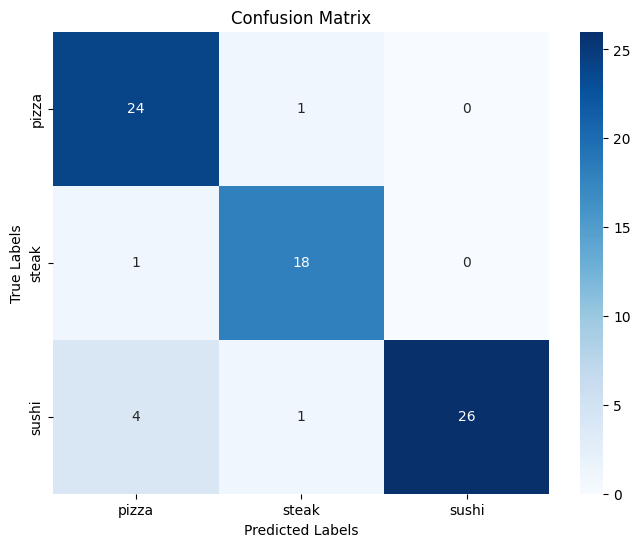

Total Accuracy: 0.9067

Accuracy per category:
  pizza: 0.9600
  steak: 0.9474
  sushi: 0.8387


In [22]:
mobilev3.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = mobilev3(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Overall accuracy
overall_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

class_names = list(train_dataset.class_to_idx.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"Total Accuracy: {overall_accuracy:.4f}")

print("\nAccuracy per category:")
for i, class_name in enumerate(class_names):
    true_positives = conf_matrix[i, i]
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives
    total_actual = true_positives + false_negatives

    if total_actual > 0:
        accuracy = true_positives / total_actual
        print(f"  {class_name}: {accuracy:.4f}")
    else:
        print(f"  {class_name}: No true instances in test set")

In [23]:
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
print(f"Index to class mapping: {idx_to_class}")

# Initialize a dictionary to store indices for each class
class_to_indices = {class_id: [] for class_id in range(len(idx_to_class))}

# Populate class_to_indices by iterating through the test_dataset
for i, (_, label) in enumerate(test_dataset):
    class_to_indices[label].append(i)

print("Class to indices mapping populated successfully.")

Index to class mapping: {0: 'pizza', 1: 'steak', 2: 'sushi'}
Class to indices mapping populated successfully.



Processing class: pizza

Processing class: steak

Processing class: sushi


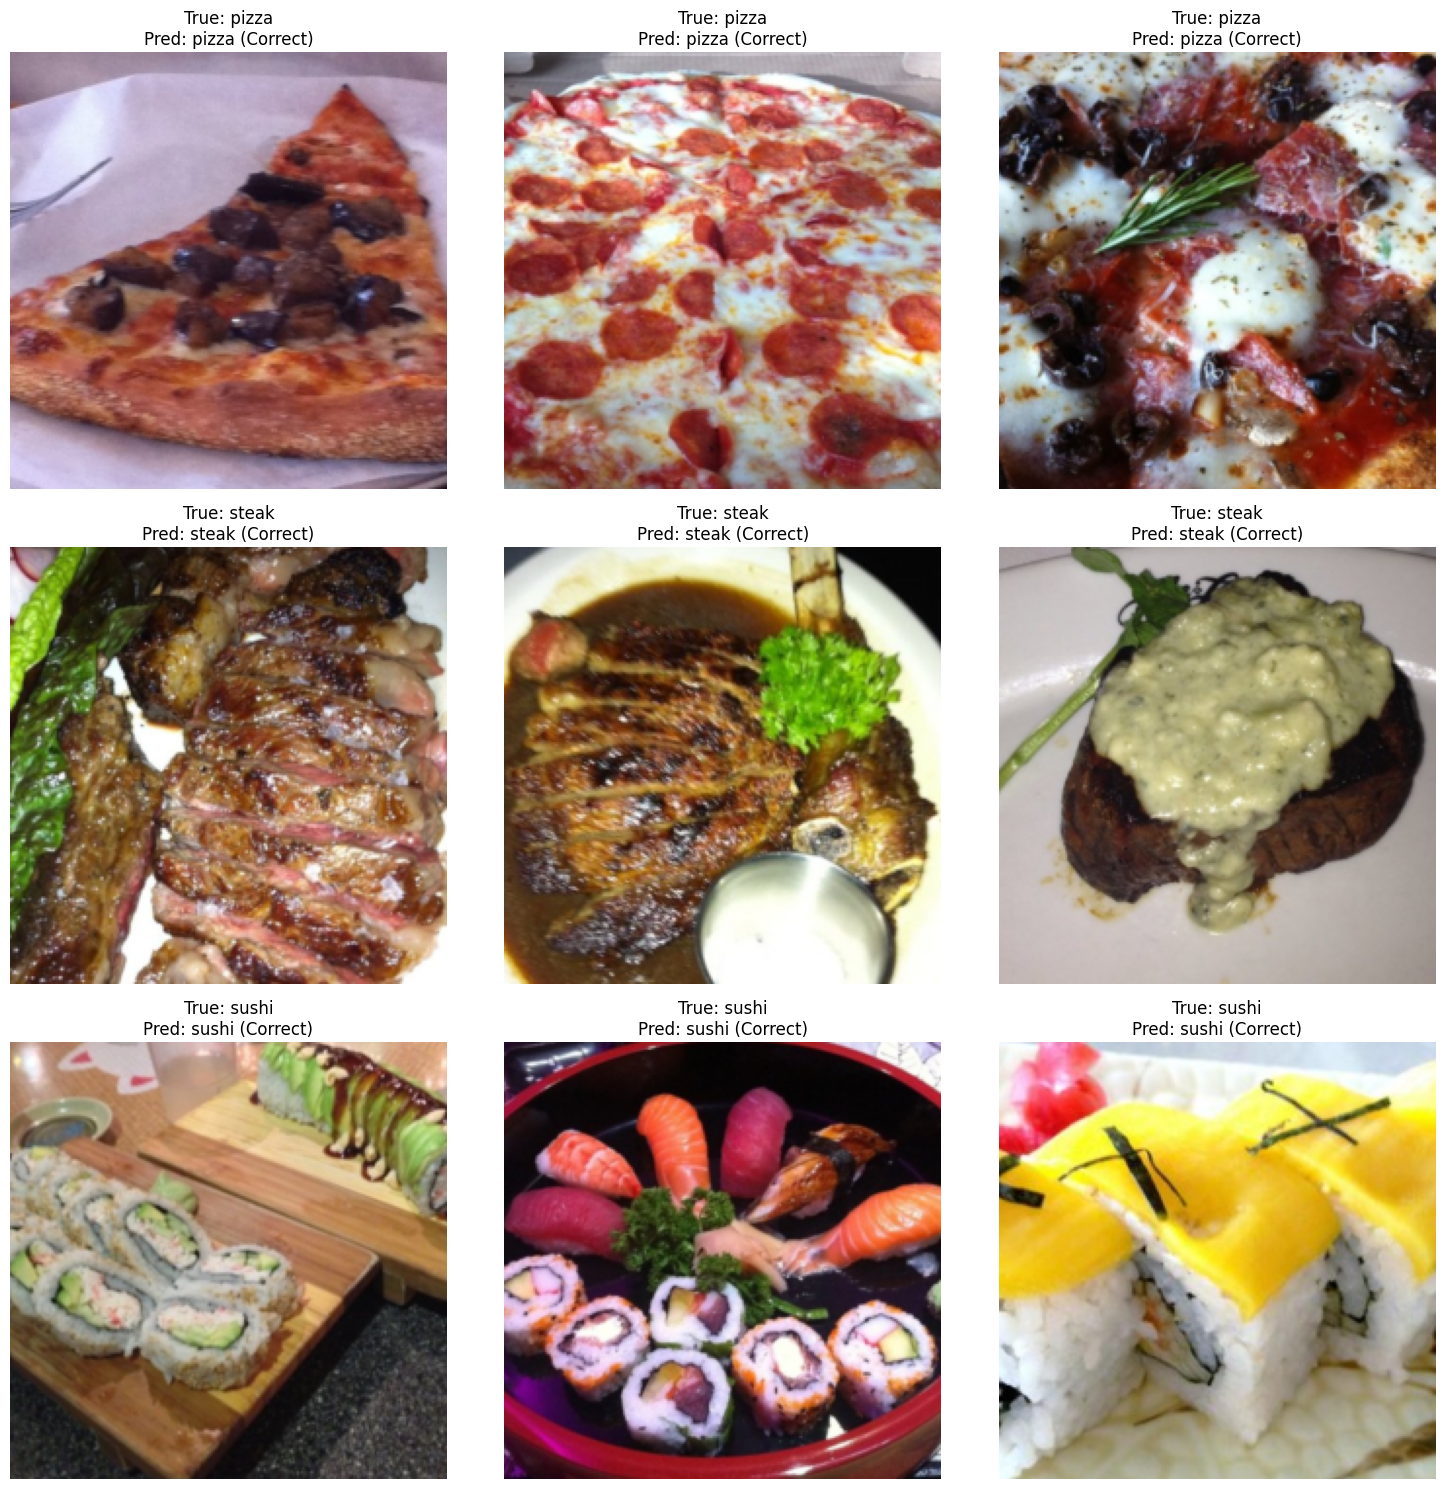

Sample image predictions and visualizations completed.


In [24]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure the model is in evaluation mode (it was already set in a previous cell, but good practice to reiterate)
mobilev3.eval()

# Denormalization for display (optional, but good for visual clarity)
def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Number of images to select per class
num_samples_per_class = 3

plt.figure(figsize=(15, 5 * len(idx_to_class)))

# Iterate through each class
for class_id, class_name in idx_to_class.items():
    # Get all indices for the current class in the test dataset
    indices = class_to_indices[class_id]

    # Randomly select num_samples_per_class images, or all if fewer are available
    selected_indices = random.sample(indices, min(len(indices), num_samples_per_class))

    print(f"\nProcessing class: {class_name}")

    for i, img_idx in enumerate(selected_indices):
        # Get the image and true label from the test_dataset
        image_tensor, true_label = test_dataset[img_idx]

        # Move the image to the device and add a batch dimension
        input_image = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = mobilev3(input_image)
            _, predicted_label_tensor = torch.max(outputs, 1)
            predicted_label = predicted_label_tensor.item()

        # Convert image tensor for display
        display_image = denormalize_image(image_tensor).cpu().numpy().transpose(1, 2, 0)
        display_image = np.clip(display_image, 0, 1) # Clip values to [0,1] for display

        true_class_name = idx_to_class[true_label]
        predicted_class_name = idx_to_class[predicted_label]
        is_correct = "Correct" if true_label == predicted_label else "Incorrect"

        # Plot the image
        plt.subplot(len(idx_to_class), num_samples_per_class, class_id * num_samples_per_class + i + 1)
        plt.imshow(display_image)
        plt.title(f"True: {true_class_name}\nPred: {predicted_class_name} ({is_correct})")
        plt.axis("off")

plt.tight_layout()
plt.show()

print("Sample image predictions and visualizations completed.")